# Standardized Testing
## 1 Setup

This dataset records test data with demographics and test prep. My objective is to demonstrate analyses of the data to act as controls and other to act as bad faith analyses to later see how partcipiants will react to the analyses.
## 1.1 Supporting Packages

In [272]:
import pandas as pd
import scipy
# from scipy.stats import ttest_ind, t
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.tree import DecisionTreeRegressor, plot_tree

## 1.2 Getting The Data
The dataset I am using is from Kaggle found here https://www.kaggle.com/datasets/spscientist/students-performance-in-exams. It includes 1000 different students recording 5 observations of their demographics (gender, race/ethnicity, parental education, their lunch, test preparation) and 3 different test scores across math, reading, and writing. 

In [273]:
df = pd.read_csv("StudentsPerformance.csv")
print(df.shape)

df

(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


## 1.2.1 Sanitization / Cleanup
The data has come in a fairly useable format from kaggle the only thing I will need to do is to one hot encode all the observations as they are all categorical. To reduce the number of redundant columns I will drop the first one when encoding.

In [274]:
tests = ["math score", "reading score", "writing score"]
features = pd.get_dummies(df.drop(tests, axis=1), drop_first=True)
print(features.shape)

features

(1000, 12)


,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,0,1,0,0,0,1,0,0,0,0,1,1
1,0,0,1,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,0,0,1,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0,1,0,0,1,0
996,1,0,1,0,0,0,1,0,0,0,0,1
997,0,0,1,0,0,0,1,0,0,0,0,0
998,0,0,0,1,0,0,0,0,1,0,1,0


## 2 Initial Analysis
Before I dive into making conclusions based on the specific nature of the data. It will be best to take a step back and look at the properties of my data frame so that wecan better understand the consequences these properties may have further on. 
## 2.1 Duplicate Feature Combinations

In [275]:
features = pd.get_dummies(df.drop(tests, axis=1), drop_first=True)
print("Shape of features: ", features.shape)
print("Unique feature rows: ", features.drop_duplicates().shape)
double_counts = features.groupby(features.columns.tolist(),as_index=False).size()['size'].value_counts()
print("Breakdown of number of duplicates:", double_counts.sort_index(), sep='\n')
print(double_counts.multiply(double_counts.index).sort_index(), double_counts.multiply(double_counts.index).sum()) # Sanity Check

for test in tests:
	knn = RadiusNeighborsRegressor(radius=0, p=1)
	knn.fit(features, df[test])
	print(test + " R^2 is " + str(knn.score(features, df[test])))

Shape of features:  (1000, 12)
Unique feature rows:  (211, 12)
Breakdown of number of duplicates:
1     29
2     37
3     32
4     26
5     23
6     14
7     13
8     11
9      7
10     1
11     5
12     2
13     4
14     2
15     2
17     1
19     1
21     1
Name: size, dtype: int64
1      29
2      74
3      96
4     104
5     115
6      84
7      91
8      88
9      63
10     10
11     55
12     24
13     52
14     28
15     30
17     17
19     19
21     21
dtype: int64 1000
math score R^2 is 0.383747836030655
reading score R^2 is 0.36593437622917757
writing score R^2 is 0.44360602438994856


By creating a Radius Neighbors Regressor with a radius of 0 we can identify how well a potential perfect model can do. As shown by the low R^2 values for each more than half of the variance could not be explained in the original dataset even if we were perfectly overfit. This makes sense though as there are a lot of students with the same background who got different scores. In fact there are only 211 distinct feature rows and of those 211 only 29 have a single observation. In fact there are 897 rows with at least a 3 row neighboorhood and 697 with at least a 5 row neighborhood.

## 2.2 Looking for biases in the dataset

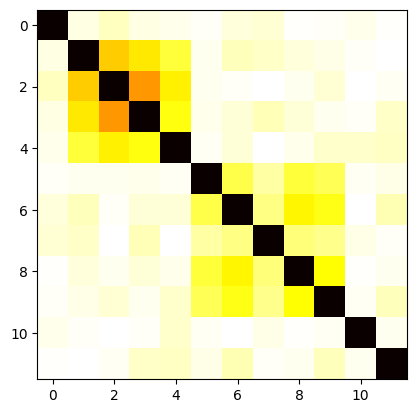

array([0.04618809, 0.05636345, 0.00162991, 0.07279254, 0.00318009,
       0.09158786, 0.12363209, 1.        , 0.13530534, 0.11691928,
       0.02709545, 0.0099326 ])

In [360]:
corr = abs(stats.spearmanr(features).correlation)
plt.imshow(1 - corr, cmap='hot', interpolation='none', vmin=0, vmax=1)
plt.show()

By plotting a correlation map using spearman method we can identify if there are any biases in the dataset. Since the students should have been sampled randomly it would be odd if we found a correlation between gender and whether the student was given the test prep as that would be not only unfair but could screw up our model later on. The above image shows mostly no correlation except on the identity and around two clusters. The correlation around the two clusters is to be expected however as those are the one hot encoded categories (race, parental education) which were not binary and thus should be correlated since only one of them can be hot which reveals info about the others. Everywhere else as shown in the image the correlation is nearly negligible.

In [361]:
pca = PCA(n_components=2, random_state=42)
pca.fit(features)
# # features.columns[pca.support()]
print("Explained Variance: ", pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
# pca.get_feature_names_out(features.columns)
print(pca.score(features))

pd.DataFrame(pca.components_,columns=features.columns,index = ['PC-'+str(i) for i in range(pca.n_components)]).apply(abs)
# trf = pca.transform(np.ones((1, features.shape[1])))
# pca.inverse_transform(trf)

Explained Variance:  [0.1469796  0.12244124]
0.2694208367085912
-6.191392797575543


,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
PC-0,0.292851,0.092554,0.748444,0.568537,0.057986,0.032415,0.029738,0.006058,0.056249,0.042048,0.027870,0.105956
PC-1,0.898781,0.041327,0.161257,0.214771,0.059147,0.001202,0.105524,0.037480,0.112668,0.030692,0.241988,0.173550


,math score,writing score,reading score
parental level of education,,,
associate's degree,1.987944,1.882579,1.824413
bachelor's degree,2.696347,2.657459,2.577525
high school,2.035551,1.972027,1.978498
master's degree,3.866829,3.503669,3.515012
some college,1.866076,1.957267,1.832720
some high school,2.333407,2.305310,2.267675


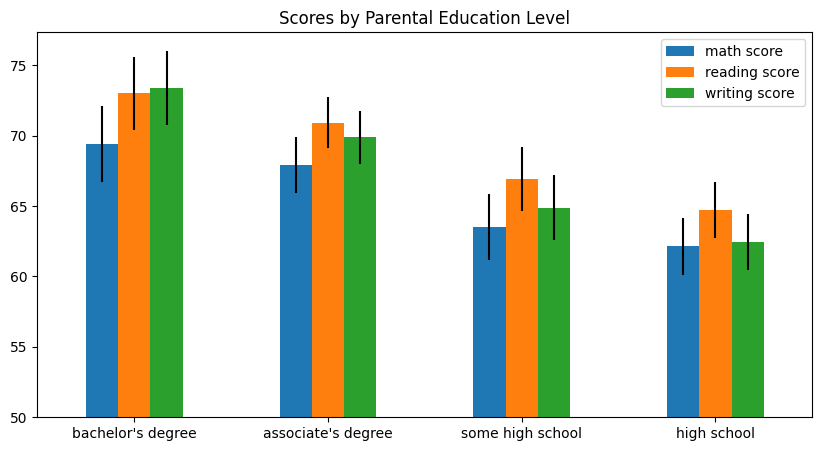

In [362]:
educ = df.groupby("parental level of education").mean().sort_values("math score", ascending=False)
err = df[tests + ["parental level of education"]].groupby("parental level of education").sem() * 1.96
degrees = ["bachelor's degree", "associate's degree", "some high school", "high school"]
offset = 50
educ = educ - offset
educ.loc[degrees,:].plot.bar(bottom=offset, figsize=(10, 5), title="Scores by Parental Education Level", rot=0, table=False, yerr=err.loc[degrees], xlabel="")
err

In [363]:
z = 1.96
tests = ['math score', 'writing score', 'reading score']
for test in tests:
	print("\nStats for " + test)
	print(ttest_ind(df[df['gender'] == 'male'][test], df[df['gender'] == 'female'][test], equal_var=False))
	print("Male Confidence Interval", df[df['gender'] == 'male'][test].mean() - z*df[df['gender'] == 'male'][test].sem(), df[df['gender'] == 'male'][test].mean() + z*df[df['gender'] == 'male'][test].sem())
	print("Female Confidence Interval", df[df['gender'] == 'female'][test].mean() - z*df[df['gender'] == 'female'][test].sem(), df[df['gender'] == 'female'][test].mean() + z*df[df['gender'] == 'female'][test].sem())


print("\nReading Score\n", df.groupby('gender')['reading score'].describe())


Stats for math score


NameError: name 'ttest_ind' is not defined

Despite the fact that girls and boys both start off with the same inate ability the data here is clear that boys do better on math and girls better on reading and writing. Or is it? Through the next session I will investigate whether there is any bias in the data between girls and boys.

Also I have used the "Reading Score" score table from above to ask a question in my form as to whether girls did statistically significantly better than boys on reading. Here I hope to identify how deep participants go, will they just look at the difference in means or will they mistakenly assume the large standard deviations leave room for overlap, or will they go as far to run their own t tests as I have which show a significant difference.

In [ ]:
for col in df.columns:
	if col == 'gender' or col in tests: continue
	colM = df[df['gender'] == 'male'][col]
	colF = df[df['gender'] == 'female'][col]
	print(pd.merge(colM.value_counts(), colF.value_counts(), right_index=True, left_index=True))
# colF.value_counts() + colM.value_counts()

         race/ethnicity_x  race/ethnicity_y
group C               139               180
group D               133               129
group B                86               104
group E                71                69
group A                53                36
                    parental level of education_x  \
some college                                  108   
associate's degree                            106   
high school                                   102   
some high school                               88   
bachelor's degree                              55   
master's degree                                23   

                    parental level of education_y  
some college                                  118  
associate's degree                            116  
high school                                    94  
some high school                               91  
bachelor's degree                              63  
master's degree                                36  


In [ ]:
girls_features = features[features['gender_male'] == 0].drop('gender_male', axis=1)
boys_features = features[features['gender_male'] == 1].drop('gender_male', axis=1)
print(boys_features.shape, girls_features.shape)
(boys_features.describe() - girls_features.describe()).loc['mean']

(482, 11) (518, 11)


race/ethnicity_group B                          -0.022349
race/ethnicity_group C                          -0.059109
race/ethnicity_group D                           0.026899
race/ethnicity_group E                           0.014098
parental level of education_bachelor's degree   -0.007514
parental level of education_high school          0.030151
parental level of education_master's degree     -0.021780
parental level of education_some college        -0.003733
parental level of education_some high school     0.006897
lunch_standard                                   0.020467
test preparation course_none                    -0.005783
Name: mean, dtype: float64